# Trees

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 200
np.set_printoptions(precision=3)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [ ]:
print(cancer.DESCR)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=0)

# tree visualization

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)

In [ ]:
# import from local file, not in sklearn yet
from tree_plotting import plot_tree

In [ ]:
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names, filled=True)

In [ ]:
print(tree_dot)

In [ ]:
plot_tree(tree, feature_names=cancer.feature_names, filled=True)

# Parameter Tuning

In [ ]:
tree = DecisionTreeClassifier().fit(X_train, y_train)
plt.figure(figsize=(15, 5))
plot_tree(tree, feature_names=cancer.feature_names, filled=True)

In [ ]:
tree = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)
plt.figure(figsize=(2, 2))
plot_tree(tree, feature_names=cancer.feature_names)

In [ ]:
tree = DecisionTreeClassifier(max_leaf_nodes=8).fit(X_train, y_train)
plot_tree(tree, feature_names=cancer.feature_names, filled=True)

In [ ]:
tree = DecisionTreeClassifier(min_samples_split=50).fit(X_train, y_train)
plot_tree(tree, feature_names=cancer.feature_names, filled=True)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':range(1, 7)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
param_grid = {'max_depth':range(1, 7)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid,
                    cv=StratifiedShuffleSplit(100), return_train_score=True)
grid.fit(X_train, y_train)

In [ ]:
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_depth', y=['mean_train_score', 'mean_test_score'], ax=plt.gca())
plt.legend(loc=(1, 0))

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_leaf_nodes':range(2, 20)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid,
                    cv=StratifiedShuffleSplit(100, random_state=1),
                   return_train_score=True)
grid.fit(X_train, y_train)

scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_leaf_nodes', y=['mean_train_score', 'mean_test_score'], ax=plt.gca())
plt.legend(loc=(1, 0))

In [ ]:
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_leaf_nodes', y='mean_train_score', yerr='std_train_score', ax=plt.gca())
scores.plot(x='param_max_leaf_nodes', y='mean_test_score', yerr='std_test_score', ax=plt.gca())

In [ ]:
grid.best_params_

In [ ]:
plot_tree(grid.best_estimator_, feature_names=cancer.feature_names, filled=True)

In [ ]:
pd.Series(grid.best_estimator_.feature_importances_,
          index=cancer.feature_names).plot(kind="barh")

# Extrapolation

In [ ]:
import os
ram_prices = pd.read_csv("data/ram_price.csv")

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date:
X_train = data_train.date[:, np.newaxis]
# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

In [ ]:
plt.semilogy(data_train.date, data_train.price, label="Training data", c='k')
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(data_train.date, np.exp(tree.predict(X_train)), '--', label="Tree prediction")
plt.semilogy(data_train.date, np.exp(linear_reg.predict(X_train)), '--', label="Linear prediction")
plt.legend()

In [ ]:
X_all = ram_prices.date[:, np.newaxis]
plt.semilogy(data_train.date, data_train.price, label="Training data", c='k')
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, np.exp(tree.predict(X_all)), '--', label="Tree prediction")
plt.semilogy(ram_prices.date, np.exp(linear_reg.predict(X_all)), '--', label="Linear prediction")
plt.legend()

# Exercise
Apply a decision tree to the "adult" dataset and visualize it.

Tune parameters with grid-search; use max_features, try at least max_leaf_nodes and max_depth, but separately.

Visualize the resulting tree and it's feature importances.

# Random Forests

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 200
np.set_printoptions(precision=3)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, stratify=digits.target, random_state=0)

In [ ]:
train_scores = []
test_scores = []

rf = RandomForestClassifier(warm_start=True)
estimator_range = range(1, 100, 5)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

In [ ]:
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()

# Exercise
Use a random forest classifier or random forest regressor on a dataset of your choice.
Try different values of n_estimators and max_depth and see how they impact performance and runtime.
Tune ``max_features`` with GridSearchCV.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)

In [4]:
# tree visualization

In [5]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [6]:
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names)

In [7]:
print(tree_dot)

digraph Tree {
node [shape=box] ;
0 [label="worst perimeter <= 106.1\ngini = 0.468\nsamples = 426\nvalue = [159, 267]"] ;
1 [label="worst concave points <= 0.134\ngini = 0.081\nsamples = 259\nvalue = [11, 248]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.008\nsamples = 240\nvalue = [1, 239]"] ;
1 -> 2 ;
3 [label="gini = 0.499\nsamples = 19\nvalue = [10, 9]"] ;
1 -> 3 ;
4 [label="worst concave points <= 0.142\ngini = 0.202\nsamples = 167\nvalue = [148, 19]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.497\nsamples = 37\nvalue = [20, 17]"] ;
4 -> 5 ;
6 [label="gini = 0.03\nsamples = 130\nvalue = [128, 2]"] ;
4 -> 6 ;
}


In [8]:
import graphviz
graphviz.Source(tree_dot)

ModuleNotFoundError: No module named 'graphviz'

# Parameter Tuning

In [9]:
tree = DecisionTreeClassifier().fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="no_pruning")
graph

NameError: name 'graphviz' is not defined

In [10]:
tree = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="max_depth_1")
graph

NameError: name 'graphviz' is not defined

In [11]:
tree = DecisionTreeClassifier(max_leaf_nodes=8).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="max_leaf_nodes_8")
graph

NameError: name 'graphviz' is not defined

In [12]:
tree = DecisionTreeClassifier(min_samples_split=50).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="min_samples_split_50")
graph

NameError: name 'graphviz' is not defined

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':range(1, 7)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

/home/andy/checkout/scikit-learn/sklearn/model_selection/_search.py:714: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'max_depth': range(1, 7)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split10_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You 

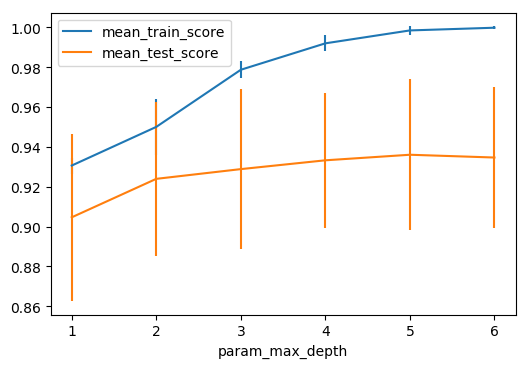

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
param_grid = {'max_depth':range(1, 7)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=StratifiedShuffleSplit(100))
grid.fit(X_train, y_train)

scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_depth', y='mean_train_score', yerr='std_train_score', ax=plt.gca())
scores.plot(x='param_max_depth', y='mean_test_score', yerr='std_test_score', ax=plt.gca())

/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split10_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You 

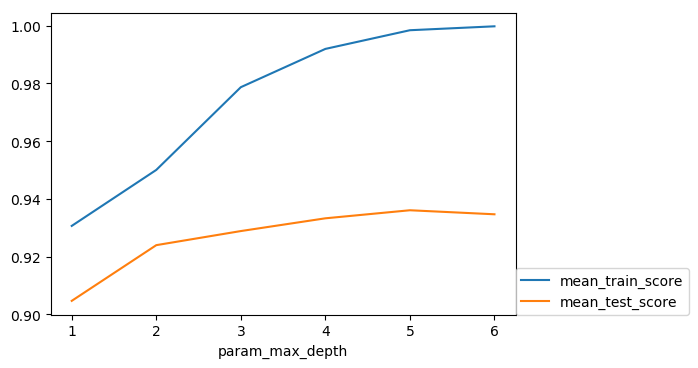

In [15]:
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_depth', y=['mean_train_score', 'mean_test_score'], ax=plt.gca())
plt.legend(loc=(1, 0))

/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split10_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You 

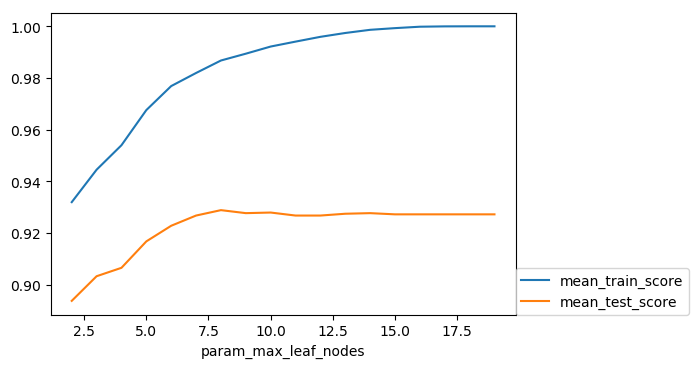

In [16]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_leaf_nodes':range(2, 20)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=StratifiedShuffleSplit(100, random_state=1))
grid.fit(X_train, y_train)

scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_leaf_nodes', y=['mean_train_score', 'mean_test_score'], ax=plt.gca())
plt.legend(loc=(1, 0))

/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split10_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/andy/checkout/scikit-learn/sklearn/utils/deprecation.py:122: FutureWarning: You 

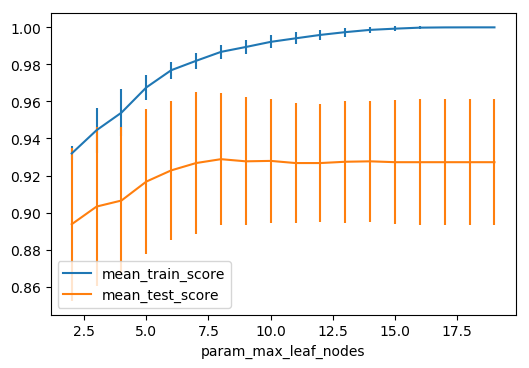

In [17]:
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_leaf_nodes', y='mean_train_score', yerr='std_train_score', ax=plt.gca())
scores.plot(x='param_max_leaf_nodes', y='mean_test_score', yerr='std_test_score', ax=plt.gca())

In [18]:
tree_dot = export_graphviz(grid.best_estimator_, out_file=None, feature_names=cancer.feature_names)
graph = graphviz.Source(tree_dot, format="png")
graph

NameError: name 'graphviz' is not defined

# Extrapolation

In [ ]:
import os
ram_prices = pd.read_csv("ram_price.csv")

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date:
X_train = data_train.date[:, np.newaxis]
# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

In [ ]:
plt.semilogy(data_train.date, data_train.price, label="Training data", c='k')
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(data_train.date, np.exp(tree.predict(X_train)), '--', label="Tree prediction")
plt.semilogy(data_train.date, np.exp(linear_reg.predict(X_train)), '--', label="Linear prediction")
plt.legend()

In [ ]:
X_all = ram_prices.date[:, np.newaxis]
plt.semilogy(data_train.date, data_train.price, label="Training data", c='k')
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, np.exp(tree.predict(X_all)), '--', label="Tree prediction")
plt.semilogy(ram_prices.date, np.exp(linear_reg.predict(X_all)), '--', label="Linear prediction")
plt.legend()

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, stratify=iris.target, random_state=0)
tree = DecisionTreeClassifier(max_leaf_nodes=6).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=iris.feature_names)
graphviz.Source(tree_dot)

In [ ]:
tree.feature_importances_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, stratify=iris.target, random_state=1)
tree = DecisionTreeClassifier(max_leaf_nodes=6).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=iris.feature_names)
graphviz.Source(tree_dot)

In [ ]:
tree.feature_importances_

In [ ]:
plt.barh(range(4), tree.feature_importances_)
plt.yticks(range(4), iris.feature_names)

# Voting Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.datasets import make_moons
X, y = make_moons(noise=.2, random_state=18) # carefully picked random state for illustration
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

voting = VotingClassifier([('logreg', LogisticRegression(C=100)),
                           ('tree', DecisionTreeClassifier(max_depth=3, random_state=0))],
                         voting='soft')
voting.fit(X_train, y_train)
lr, tree = voting.estimators_
print(("{:.2f} " * 3).format(voting.score(X_test, y_test),
                             lr.score(X_test, y_test), tree.score(X_test, y_test)))


In [ ]:
x_lin = np.linspace(X_train[:, 0].min() - .5, X_train[:, 0].max() + .5, 100)
y_lin = np.linspace(X_train[:, 1].min() - .5, X_train[:, 1].max() + .5, 100)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
# transform produces individual probabilities
lr_probs, tree_probs =  voting.transform(X_grid)

In [ ]:
fig, axes = plt.subplots(1, 3, subplot_kw={'xticks': (()), 'yticks': (())}, figsize=(5, 2))
for prob, ax in zip([lr_probs, tree_probs, lr_probs + tree_probs], axes.ravel()):
    ax.contourf(x_grid, y_grid, prob[:, 1].reshape(x_grid.shape), alpha=.4, cmap='bwr')
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=10)

In [ ]:
voting.estimators_[0].score(X_test, y_test)

In [ ]:
voting.estimators_[1].score(X_test, y_test)

In [ ]:
voting.score(X_test, y_test)

# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, stratify=digits.target, random_state=0)

In [ ]:
train_scores = []
test_scores = []

rf = RandomForestClassifier(warm_start=True)
estimator_range = range(1, 100, 5)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

In [ ]:
plt.plot(estimator_range, test_scores, label="train scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()

In [ ]:
train_scores = []
test_scores = []
oob_scores = []

feature_range = range(1, 64, 5)
for max_features in feature_range:
    rf = RandomForestClassifier(max_features=max_features, oob_score=True, n_estimators=200, random_state=0)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

In [ ]:
plt.plot(feature_range, test_scores, label="test scores")
plt.plot(feature_range, oob_scores, label="oob_scores scores")
plt.plot(feature_range, train_scores, label="train scores")
plt.legend()
plt.ylabel("accuracy")
plt.xlabel("max_features")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, stratify=iris.target, random_state=1)
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [ ]:
rf.feature_importances_

In [ ]:
plt.barh(range(4), rf.feature_importances_)
plt.yticks(range(4), iris.feature_names);